In [18]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import datasets
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn import cluster
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
from sklearn import metrics
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.metrics import confusion_matrix
from matplotlib import ticker
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
# !pip install py7zr
# import py7zr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

In [4]:
def calculate_f_measure(y,labels):
  cm = confusion_matrix(y, labels)
  indexes = linear_assignment(_make_cost_m(cm))
  # js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
  cm2 = cm[:, indexes[1]]

  acc = np.trace(cm2) / np.sum(cm2)
  precision = np.nanmean(np.diag(cm2) / np.sum(cm2, axis = 0))
  recall = np.nanmean(np.diag(cm2) / np.sum(cm2, axis = 1))
  f1 = 2 * precision * recall / (precision + recall)
  return f1

def evaluate_clustering(labels, predictions, beta=1.0):
  rand_index = metrics.rand_score(labels, predictions)
  nmi = metrics.normalized_mutual_info_score(labels, predictions)
  f_measure = calculate_f_measure(labels, predictions)
  print('Rand Index: %f, NMI: %f, F-measure: %f' % (rand_index, nmi, f_measure))
  return


In [62]:
#archive = py7zr.SevenZipFile('/content/face_encodings.7z', mode='r')
#archive.extractall(path="/content")
#archive.close()

# df = pd.read_csv('/content/face_encodings.csv')
df = pd.read_csv('/content/drive/MyDrive/face_encodings.csv')
y = df['target']
df = df.drop('target', axis=1)
kmeans = KMeans(n_clusters=105,n_init=20, max_iter=500)
kmeans.fit(df)
labels = kmeans.labels_
evaluate_clustering(y,labels)

Rand Index: 0.995066, NMI: 0.896850, F-measure: 0.886755


In [57]:
dbscan = DBSCAN(eps=0.4, min_samples=5, metric='euclidean',n_jobs=-1)
dbscan.fit(df)
labels = dbscan.labels_
evaluate_clustering(y, labels)
# clusterer = OPTICS(min_samples=5)
# y_pred = cluster.AgglomerativeClustering(n_clusters=None, distance_threshold=1.14, linkage='single').fit_predict(df1)
# evaluate_clustering(y, y_pred)

Rand Index: 0.905642, NMI: 0.726784, F-measure: 0.759427


<ipython-input-4-a9a7f9a9b946>:9: RuntimeWarning: invalid value encountered in true_divide
  recall = np.nanmean(np.diag(cm2) / np.sum(cm2, axis = 1))


In [58]:
len(set(labels))

115

OPTIMIZING DBSCAN

In [65]:
df1=df.copy()
scaler = StandardScaler()
scaler.fit(df1)
df1 = scaler.transform(df)

In [66]:
pca = PCA(n_components=100)
df1 = pca.fit_transform(df1)
print(f"Explained variance sum = {sum(pca.explained_variance_ratio_)}")

Explained variance sum = 0.9999999999996421


In [76]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15)
X_embedded = tsne.fit_transform(df1)

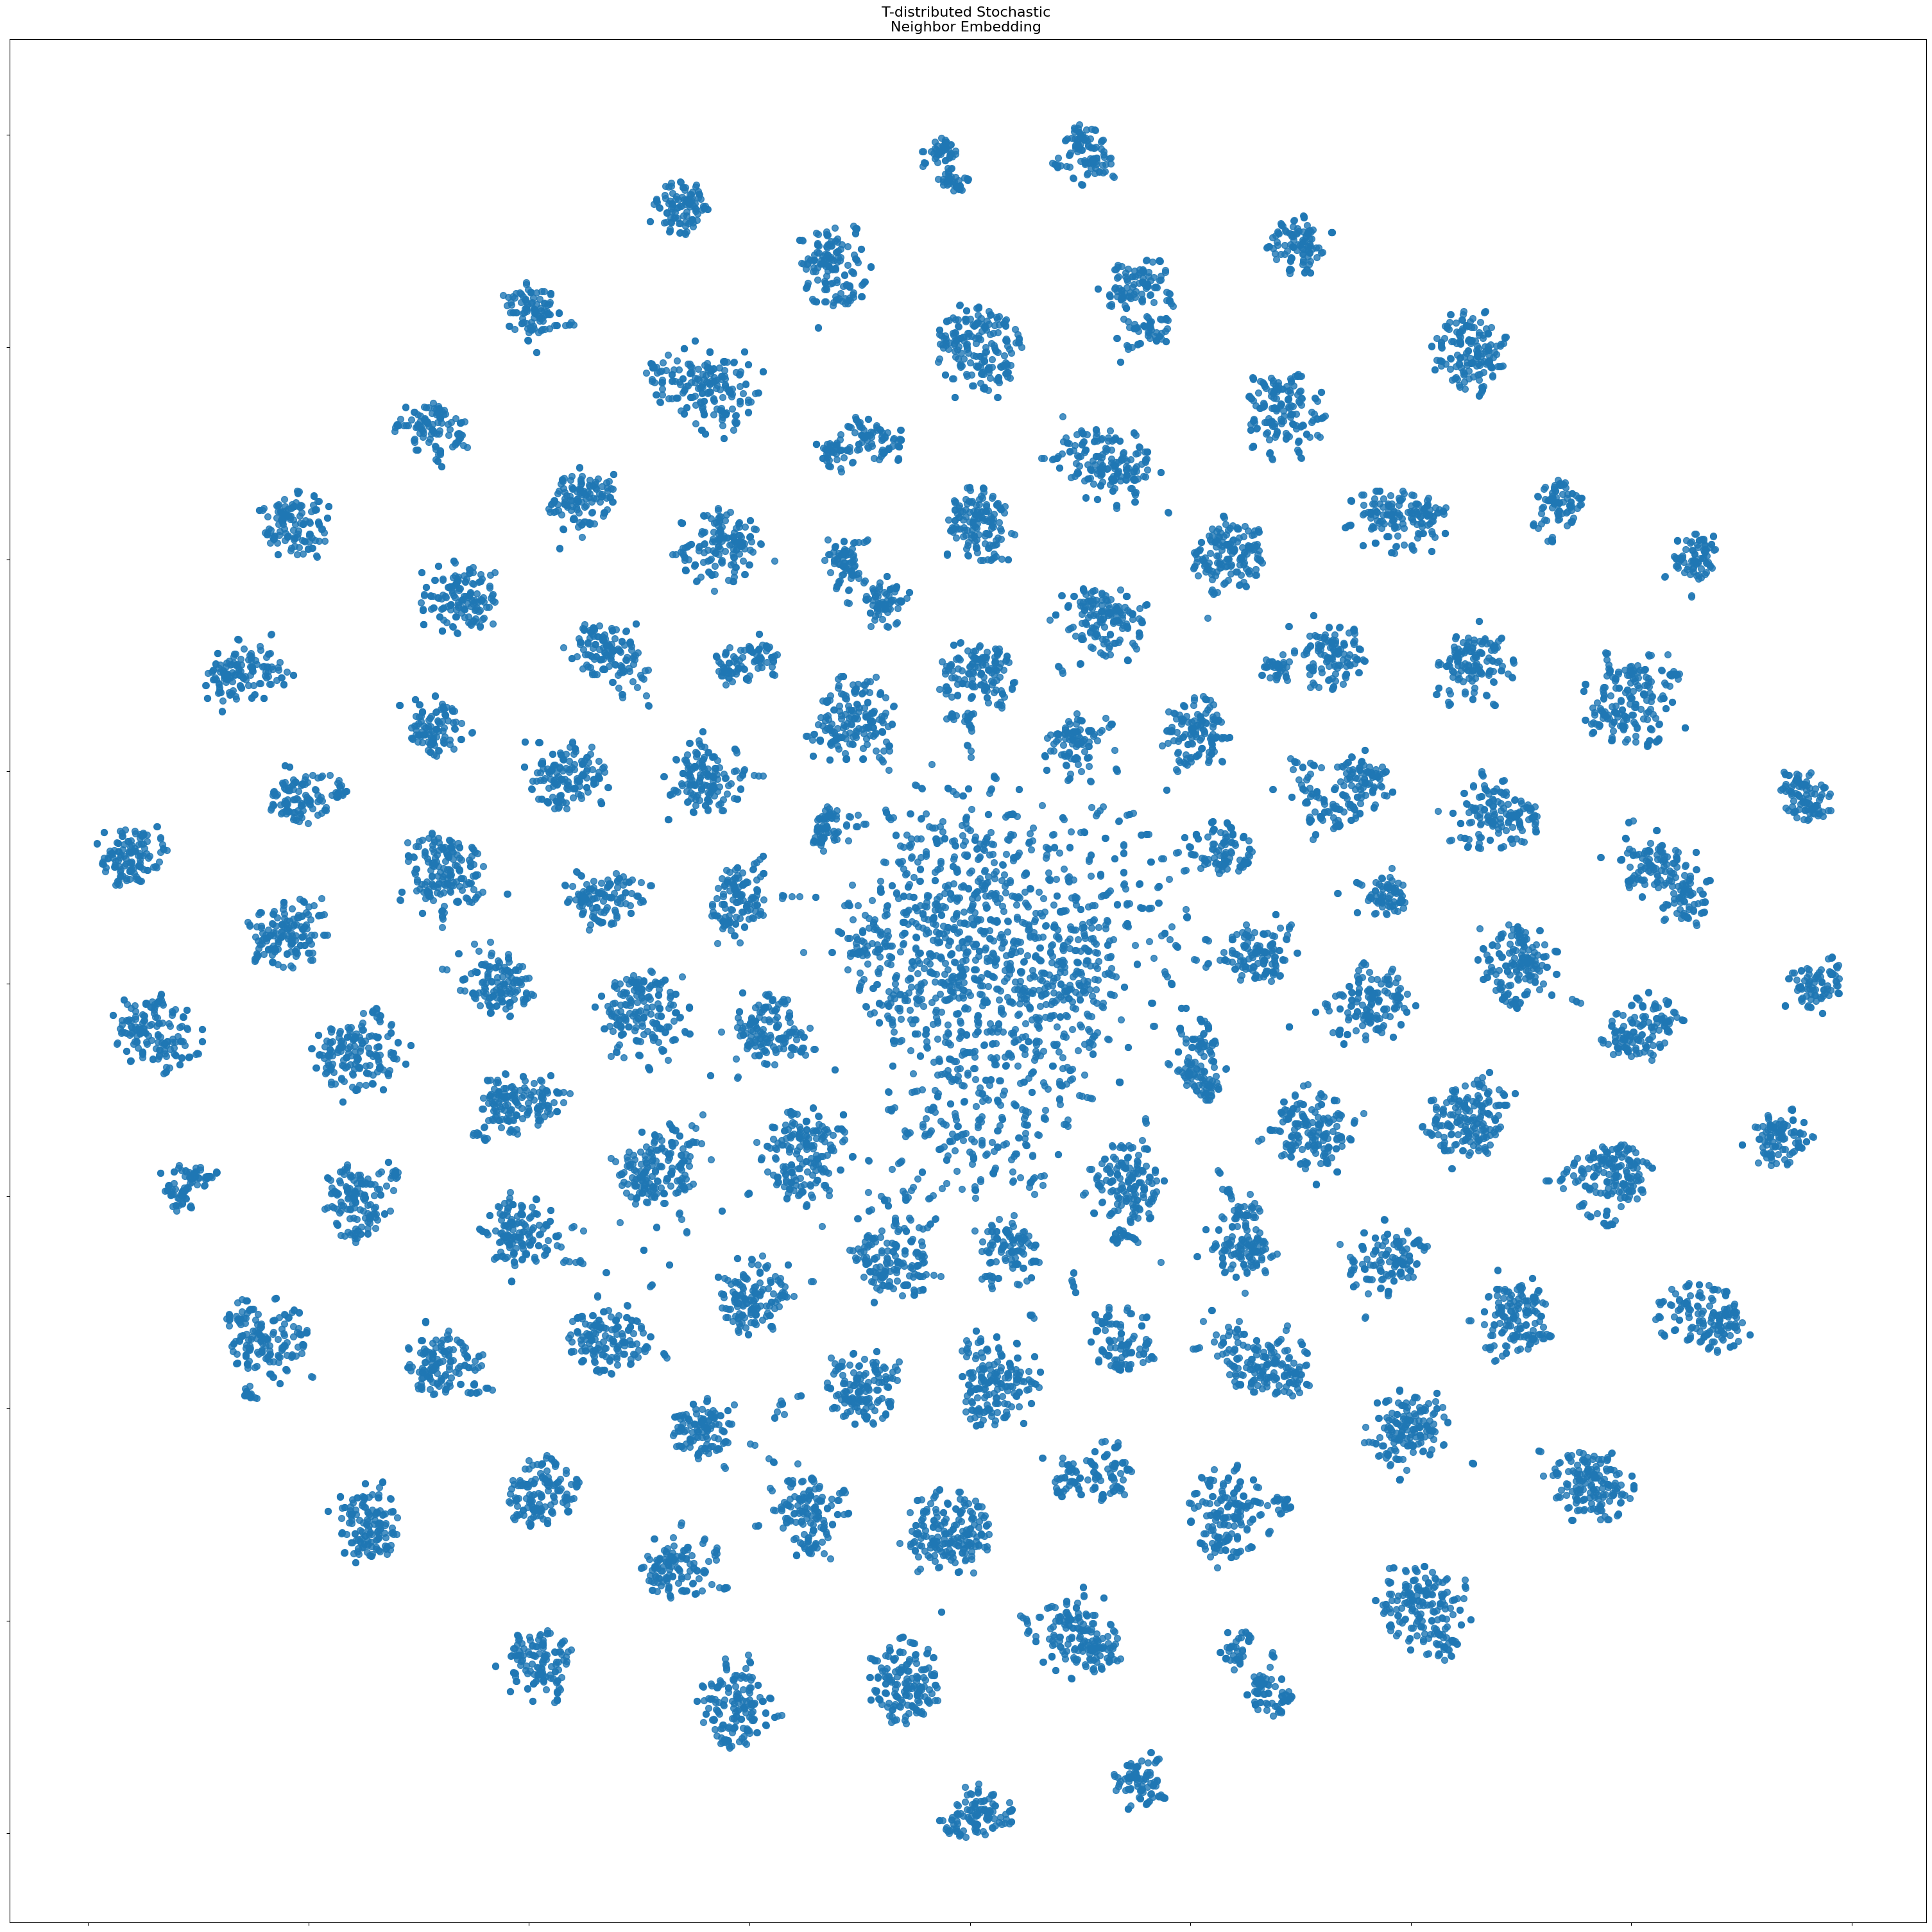

In [77]:
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(30, 30), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

plot_2d(X_embedded, 128, "T-distributed Stochastic\nNeighbor Embedding")

In [67]:
nn = NearestNeighbors(n_neighbors=200).fit(df1)
distances, indices = nn.kneighbors(df1)

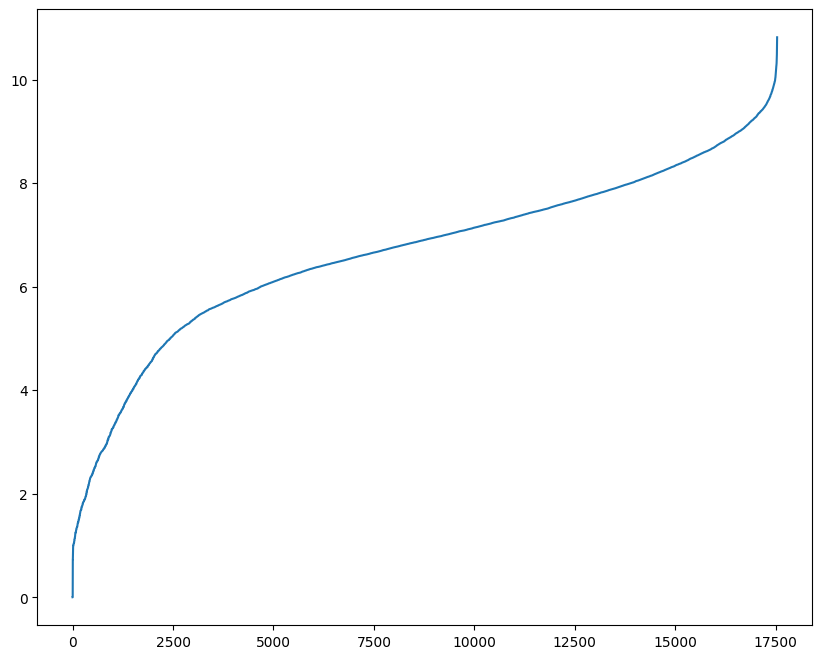

In [68]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)

In [69]:
min_samples = range(4,20)
eps = np.arange(7,9, 0.1)

In [70]:
output = []
for ms in min_samples:
    for ep in eps:
        labels = DBSCAN(min_samples=ms, eps = ep).fit(df1).labels_
        score = silhouette_score(df1, labels)
        output.append((ms, ep, score))

In [71]:
min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

Best silhouette_score: 0.1700906008972732
min_samples: 10
eps: 8.599999999999994


In [72]:
labels = DBSCAN(min_samples=min_samples, eps = eps).fit(df1).labels_
clusters = len(Counter(labels))
print(f"Number of clusters: {clusters}")
print(f"Number of outliers: {Counter(labels)[-1]}")
print(f"Silhouette_score: {silhouette_score(df1, labels)}")
evaluate_clustering(y,labels)

Number of clusters: 100
Number of outliers: 2583
Silhouette_score: 0.1700906008972732
Rand Index: 0.970814, NMI: 0.816850, F-measure: 0.837963


<ipython-input-4-a9a7f9a9b946>:8: RuntimeWarning: invalid value encountered in true_divide
  precision = np.nanmean(np.diag(cm2) / np.sum(cm2, axis = 0))
<ipython-input-4-a9a7f9a9b946>:9: RuntimeWarning: invalid value encountered in true_divide
  recall = np.nanmean(np.diag(cm2) / np.sum(cm2, axis = 1))


In [73]:
kmeans = KMeans(n_clusters=clusters,n_init=20, max_iter=500)
kmeans.fit(df)
labels = kmeans.labels_
evaluate_clustering(y,labels)

Rand Index: 0.994521, NMI: 0.892720, F-measure: 0.877064


<ipython-input-4-a9a7f9a9b946>:8: RuntimeWarning: invalid value encountered in true_divide
  precision = np.nanmean(np.diag(cm2) / np.sum(cm2, axis = 0))


OPTIMIZING K-MEANS

In [74]:
# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# from sklearn import datasets


# Define the range of K (number of clusters) to evaluate
k_values = range(clusters-20, clusters+20)
silhouette_scores = []

# Compute silhouette score for each K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Find the optimal number of clusters with the highest silhouette score
optimal_cluster_index = np.argmax(silhouette_scores)
optimal_cluster = k_values[optimal_cluster_index]

print("Optimal number of clusters:", optimal_cluster)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Optimal number of clusters: 115


In [75]:
kmeans = KMeans(n_clusters=optimal_cluster,n_init=20, max_iter=500)
kmeans.fit(df)
labels = kmeans.labels_
evaluate_clustering(y,labels)

Rand Index: 0.996565, NMI: 0.896603, F-measure: 0.885641


<ipython-input-4-a9a7f9a9b946>:9: RuntimeWarning: invalid value encountered in true_divide
  recall = np.nanmean(np.diag(cm2) / np.sum(cm2, axis = 1))
